In [1]:
import os
import requests
import torch

from src.tokenizer import CharTokenizer

__file__='shakespeare_data/'

# download the tiny shakespeare dataset
input_file_path = os.path.join(os.path.dirname(__file__), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)


#create the tokenizer
tokenizer=CharTokenizer(input_file_path)
print('tokenizer vocab size:', tokenizer.vocab_size)


length of dataset in characters: 1,115,394
tokenizer vocab size: 65


In [2]:
# load the data
with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")


# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = tokenizer(train_data)
val_ids = tokenizer(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
torch.save(train_ids, os.path.join(os.path.dirname(__file__), 'train.bin'))
torch.save(val_ids,   os.path.join(os.path.dirname(__file__), 'val.bin'))

length of dataset in characters: 1,115,394
train has 1,003,854 tokens
val has 111,540 tokens


In [3]:
import torch
from torch import nn
from IPython.display import clear_output

from src.encoder import Encoder, GPT2Encoder
from src.decoder import Decoder, GPT2Decoder
from src.graph_initialization import random_unidirectional_graph_maker, linear_unidirectional_graph_maker
from src.graphAN import GraphAttentionNetwork, BlockGenerator
from src.data_loader import validation
from src.tokenizer import Tokenizer
from src.GPT2 import GPT2_Block, GPT2
from matplotlib import pyplot as plt
from src.utils import moving_average, grad_norm
from torch.nn.utils import clip_grad_norm_
import pickle
import numpy as np
from termcolor import colored



In [4]:
device = 'cpu'
#device = 'mps'  if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device

dV = 16
dV = 16
heads = 6
d_Embedding = dV*heads
intermediate_size=intermediate_size=2*d_Embedding


encoder = Encoder(d_Embedding, tokenizer, dropout=0, device=device)
decoder = Decoder(encoder)
block_generator = BlockGenerator(GPT2_Block, d_Embedding, dV, dV, heads, intermediate_size,
                                 dropout=0.3, split_size=2**10, device=device, rotary_encoding=False)

model = GraphAttentionNetwork(tokenizer, encoder, block_generator, decoder, n_blocks=6)
model.losses = []
model.validation_losses = []

#model.load('shakespeare_data/pretrained_CE=1.3.pth')

print(f'number of parameters:{model.n_parameters}')

graph_maker = linear_unidirectional_graph_maker(50, device=device)

number of parameters:454848


In [5]:
from src.decoder import Loss

loss_function = Loss(decoder)
ce_loss = nn.CrossEntropyLoss()

lr = 8e-4
gamma = 0.99

grad_norms = []

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

In [6]:
from numpy.random import randint
def sample_shakespeare(data, lenght, starting_index=None):
    lenght=int(lenght)
    
    if starting_index is None:
        starting_index = randint(0, len(data)-lenght)

    if starting_index+lenght>=len(data):
        return data[starting_index:]    
    
    return data[starting_index:starting_index+lenght]


N:959000/1003854
Validation loss: 2.95


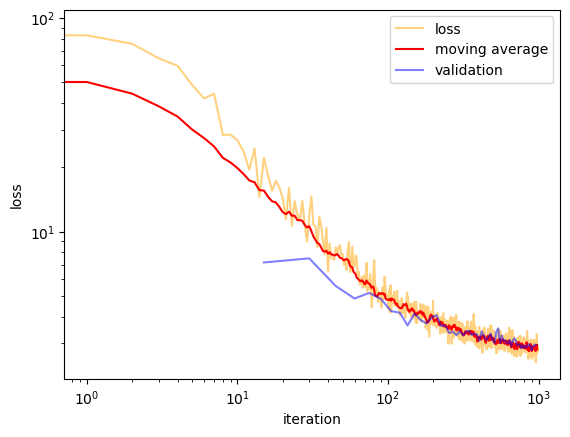

KeyboardInterrupt: 

In [9]:
#@title {vertical-output: true}
#@markdown # Training
#@markdown the loss function is cross entropy ❌🎲

n_epochs = int(1000)
model.train()
context_size=2e2
model.train()
for i in range(n_epochs):

    
    inp=sample_shakespeare(train_ids, context_size)

    nodes = inp[:-1]
    targets = inp[1:]
    edge_index = graph_maker(nodes.shape[0])
    prediction = model(nodes, edge_index)
    loss = loss_function(prediction, targets)

    #print(f'N:{int(i*1e3)}/{len(train_ids)}, tokens:{nodes.shape[0]}, loss:{loss.item():.2f}')
    model.losses.append(loss.item())
    loss.backward()

    #gn = grad_norm(model)
    #print(f'grad_norm:{gn:.2f}')
    #grad_norms.append(gn)
    clip_grad_norm_(model.parameters(), 4*loss.item())

    optimizer.step()
    optimizer.zero_grad()  # reinitialize the gradient to zero

    if i%15==14:
        clear_output()
        scheduler.step()

        m_av = moving_average(model.losses, 10)
        model.best_loss = min(m_av)
        print(f'N:{int(i*1e3)}/{len(train_ids)}, tokens:{nodes.shape[0]}, loss:{m_av.item():.2f}')

        if model.best_loss<2:
            context_size=1e3

        if model.best_loss<1.5:
            context_size=5e3

        inp=sample_shakespeare(val_ids, 1e3)
        nodes=inp[:-1]
        targets=inp[1:]
        edge_index = graph_maker(nodes.shape[0])
        prediction = model(nodes, edge_index)
        validation_loss = loss_function(prediction, targets)

        model.validation_losses.append(validation_loss.item())

        print(f'Validation loss: {validation_loss:.2f}')

        plt.plot(model.losses, label='loss', color='orange', alpha=0.5)
        plt.plot(m_av, label='moving average', color='red')
        plt.plot(np.arange(len(model.validation_losses))*15+15, model.validation_losses, label='validation',color='blue',alpha=0.5)

        plt.legend()
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.yscale('log')
        plt.xscale('log')
        plt.show()


In [64]:
model.eval()
#model.load('shakespeare_data/pretrained_CE=1.3.pth')
text=sample_shakespeare(val_data, 200)
embeddings=tokenizer(text)

targets=embeddings[1:]
embeddings=embeddings[:-1]
edge_index=graph_maker(embeddings.shape[0])

print('\n\n',loss_function(model(embeddings,edge_index),targets).item())
print(text)
asd=tokenizer.decode(model.final_embedding(embeddings,edge_index).argmax(dim=-1))
print('',asd)



 1.4779587984085083
: I say he shall go to prison.

GREMIO:
Take heed, Signior Baptista, lest you be
cony-catched in this business: I dare swear this
is the right Vincentio.

Pedant:
Swear, if thou darest.

GREMIO:
Nay, 
 
d wel measoat  go bouprinou.
NDRKN:OR
Nare ha ,,
Sog,itr Buv int , las, mou te con ,
atcae  tn thin turine s  t tare sae rethis
As the right nonge t ou
WPed n :
She re tf thou tare t 

GLENI :
Noy  


In [57]:
u=0
for a,b in zip(text,' '+asd):
    if a==b:
        u+=1

u/len(text)

0.595

In [62]:
n_generated=200
out=model.generate(text,n_generated,graph_maker,0.5)[-n_generated:]

In [63]:
print(f"{text}\x1b[31m{out}\x1b[0m")

ther than it shall, I will be free
Even to the uttermost, as I please, in words.

PETRUCHIO:
Why, thou say'st true; it is a paltry cap,
A custard-coffin, a bauble, a silken pie:
I love thee well, in thorte t l thorm ithathawe fn that as
COL fake.
NG werino fands pord t were sheret he fod co t I winom, my, s.
O welithere he ford as she for are prathe, sack t at ann fingo thom, d.
DWARD:
CORKINGSTES
